In [1]:
import json
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
""" Download dataset to ~/tensorflow_datasets """
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json \
    -O ~/tensorflow_datasets/sarcasm.json

--2020-12-04 11:18:21--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
wget: /Users/carlos/.netrc:2: warning: ‘login’ token appears before any machine name
wget: /Users/carlos/.netrc:3: warning: ‘password’ token appears before any machine name
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.69.128, 172.217.212.128, 172.217.214.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.69.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/Users/carlos/tensorflow_datasets/sarcasm.json’

/Users/carlos/tenso 100%[===================>]   5.38M  6.07MB/s    in 0.9s    

2020-12-04 11:18:22 (6.07 MB/s) - ‘/Users/carlos/tensorflow_datasets/sarcasm.json’ saved [5643545/5643545]



In [3]:
""" Load the dataset and explore it a bit """
with open('/Users/carlos/tensorflow_datasets/sarcasm.json', 'r') as f:
    datastore = json.load(f)

print(datastore[0])

{'article_link': 'https://www.huffingtonpost.com/entry/versace-black-code_us_5861fbefe4b0de3a08f600d5', 'headline': "former versace store clerk sues over secret 'black code' for minority shoppers", 'is_sarcastic': 0}


In [4]:
""" Separate into sentences and labels """
sentences = []
labels = []

for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

In [93]:
""" Define variables and hyperparameters """
vocab_size    = 1000
embedding_dim = 8
max_length    = 100
trunc_type    = 'post'
padding_type  = 'pre'
oov_token     = '<OOV>'
training_size = 20000

In [94]:
""" Split into training and testing datasets """
training_sentences = sentences[:training_size]
testing_sentences  = sentences[training_size:]

training_labels = labels[:training_size]
testing_labels  = labels[training_size:]

In [95]:
""" Text encoding """
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded    = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded    = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [96]:
""" Turn padded lists and labels into Numpy Arrays to be fed into the DNN """
import numpy as np

training_padded = np.array(training_padded)
training_labels = np.array(training_labels)

testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [97]:
""" Define the model """
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=tf.optimizers.Adam(),
    loss=tf.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 100, 8)            8000      
_________________________________________________________________
global_average_pooling1d_8 ( (None, 8)                 0         
_________________________________________________________________
dense_16 (Dense)             (None, 24)                216       
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 25        
Total params: 8,241
Trainable params: 8,241
Non-trainable params: 0
_________________________________________________________________


In [98]:
 """ Train the model """
 history = model.fit(
     training_padded,
     training_labels,
     epochs=30,
     validation_data=(testing_padded, testing_labels)
 )

Epoch 1/30
625/625 [==============================] - 1s 866us/step - loss: 0.6818 - accuracy: 0.5604 - val_loss: 0.6660 - val_accuracy: 0.5669
Epoch 2/30
625/625 [==============================] - 0s 730us/step - loss: 0.5669 - accuracy: 0.7119 - val_loss: 0.4780 - val_accuracy: 0.7721
Epoch 3/30
625/625 [==============================] - 0s 740us/step - loss: 0.4291 - accuracy: 0.8061 - val_loss: 0.4254 - val_accuracy: 0.8030
Epoch 4/30
625/625 [==============================] - 0s 728us/step - loss: 0.3946 - accuracy: 0.8218 - val_loss: 0.4148 - val_accuracy: 0.8050
Epoch 5/30
625/625 [==============================] - 0s 722us/step - loss: 0.3791 - accuracy: 0.8284 - val_loss: 0.4039 - val_accuracy: 0.8159
Epoch 6/30
625/625 [==============================] - 0s 772us/step - loss: 0.3710 - accuracy: 0.8305 - val_loss: 0.4105 - val_accuracy: 0.8077
Epoch 7/30
625/625 [==============================] - 1s 804us/step - loss: 0.3647 - accuracy: 0.8351 - val_loss: 0.4020 - val_accuracy:

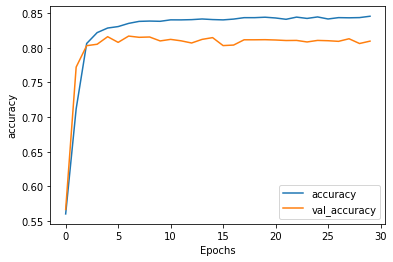

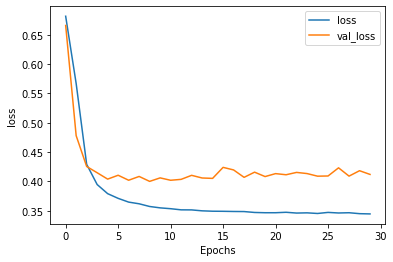

In [99]:
""" Plot the training """
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_' + metric])
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend([metric, 'val_' + metric])
    plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [100]:
""" Turn word index back into words to be used with projector.tensorflow.com """
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

# show an example of the reversed word index along with the an example from the original sentences and labels
print(decode_sentence(training_padded[0]))
print(training_sentences[2])
print(labels[2])

? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? former <OOV> store <OOV> <OOV> over secret <OOV> <OOV> for <OOV> <OOV>
mom starting to fear son's web series closest thing she will have to grandchild
1


In [101]:
""" Get the embedding layer's weights """
embedding = model.layers[0]
weights = embedding.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(1000, 8)


In [102]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [103]:
""" Try to classify a real example """
sentence = ["granny starting to fear spiders in the garden might be real", "game of thrones season finale showing this sunday night"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.predict(padded))

[[0.31821126]
 [0.56659114]]
